In [17]:
# Larger LSTM Network to Generate Text for Alice in Wonderland
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import os
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import math        #import needed modules
import pyaudio     #sudo apt-get install python-pyaudio
import pandas as pd

In [88]:
epochs = 50
stepsPerEpochs=10
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"

In [3]:

# load ascii text and covert to lowercase
filename = "wonderland.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

In [4]:
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Characters:  164200
Total Vocab:  64
Total Patterns:  164100


In [5]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# define the checkpoint

In [99]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [100]:

if os.path.isfile(filepath):
    model.load_weights(filepath)

mc = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=0.000001)
callbacks=[es, mc]

In [101]:

# fit the model
history = model.fit(X, y, epochs=epochs, steps_per_epoch=stepsPerEpochs, batch_size=64, callbacks=callbacks)
print(history)

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 3.7159 - accuracy: 0.1484
Epoch 00001: loss improved from inf to 3.71591, saving model to weights-improvement-01-3.7159-bigger.hdf5
10/10 [==============================] - 9s 888ms/step - loss: 3.7159 - accuracy: 0.1484
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 3.2582 - accuracy: 0.1469
Epoch 00002: loss improved from 3.71591 to 3.25821, saving model to weights-improvement-02-3.2582-bigger.hdf5
10/10 [==============================] - 9s 891ms/step - loss: 3.2582 - accuracy: 0.1469
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 3.1971 - accuracy: 0.1594
Epoch 00003: loss improved from 3.25821 to 3.19707, saving model to weights-improvement-03-3.1971-bigger.hdf5
10/10 [==============================] - 10s 957ms/step - loss: 3.1971 - accuracy: 0.1594
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 3.1407 - accuracy: 0.1516
Epoch 00004: loss improved fro

Epoch 34/50
10/10 [==============================] - ETA: 0s - loss: 3.1187 - accuracy: 0.1688
Epoch 00034: loss did not improve from 3.06422
10/10 [==============================] - 9s 909ms/step - loss: 3.1187 - accuracy: 0.1688
Epoch 35/50
10/10 [==============================] - ETA: 0s - loss: 3.0473 - accuracy: 0.1500
Epoch 00035: loss improved from 3.06422 to 3.04726, saving model to weights-improvement-35-3.0473-bigger.hdf5
10/10 [==============================] - 9s 923ms/step - loss: 3.0473 - accuracy: 0.1500
Epoch 36/50
10/10 [==============================] - ETA: 0s - loss: 3.1603 - accuracy: 0.1625
Epoch 00036: loss did not improve from 3.04726
10/10 [==============================] - 9s 919ms/step - loss: 3.1603 - accuracy: 0.1625
Epoch 37/50
10/10 [==============================] - ETA: 0s - loss: 3.1111 - accuracy: 0.1453
Epoch 00037: loss did not improve from 3.04726
10/10 [==============================] - 9s 914ms/step - loss: 3.1111 - accuracy: 0.1453
Epoch 38/50
1

In [9]:
history.history

{'loss': [4.117135047912598,
  3.9187393188476562,
  3.4975266456604004,
  3.2837557792663574,
  3.4891724586486816,
  3.26954984664917,
  3.1706724166870117,
  3.27262282371521,
  3.1138594150543213,
  3.347722053527832,
  3.2171430587768555,
  3.1497151851654053,
  3.2265210151672363,
  3.1843934059143066,
  3.2027668952941895,
  2.8934686183929443,
  3.1528449058532715,
  3.303898572921753,
  3.073211193084717,
  3.1858415603637695,
  3.368297815322876,
  3.124680995941162,
  3.121399402618408,
  3.184054374694824,
  3.2666120529174805,
  3.1472129821777344,
  3.1150474548339844,
  3.1952195167541504,
  3.1278839111328125,
  3.1908483505249023,
  3.0131444931030273,
  3.1499576568603516,
  3.1697189807891846,
  3.109543800354004,
  3.0840225219726562,
  3.007689952850342,
  2.988460063934326,
  3.210446834564209,
  3.054349184036255,
  3.0753097534179688,
  3.0228114128112793,
  3.262930154800415,
  3.1420955657958984,
  3.028447151184082,
  3.1211304664611816,
  2.9831600189208984,

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

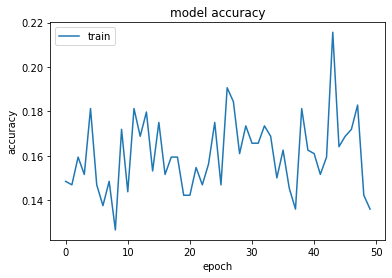

In [102]:
time = datetime.now()
timestampStr = time.strftime("%d %b %Y %H %M %S %f)")
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\env\\lib\\site-packages\\matplotlib\\pyplot.py'>

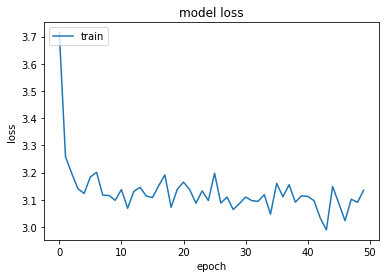

In [103]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss"+timestampStr+".png")
plt

In [107]:
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters

x = numpy.reshape(pattern, (1, len(pattern), 1))
x = x / float(n_vocab)
prediction = model.predict(x, verbose=0)

index = numpy.argmax(prediction)
result = int_to_char[index]
seq_in = [int_to_char[value] for value in pattern]
sys.stdout.write(result)
#print(result)
pattern.append(index)
pattern = pattern[1:len(pattern)]

print('\nPredict')
print(''.join(seq_in))
print ("\nDone.")

Seed:
"  executions the queen had ordered.

they very soon came upon a gryphon, lying fast asleep in the sun "
 
Predict
 executions the queen had ordered.

they very soon came upon a gryphon, lying fast asleep in the sun

Done.


In [108]:
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    #print(result)
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")
print(''.join(seq_in))

Seed:
" ke such a dreadful time.”

so alice began telling them her adventures from the time when she first
s "
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [55]:

def playNote(nota):
    PyAudio = pyaudio.PyAudio     #initialize pyaudio

    #See https://en.wikipedia.org/wiki/Bit_rate#Audio
    BITRATE = 16000     #number of frames per second/frameset.      

    FREQUENCY = nota     #Hz, waves per second, 261.63=C4-note.
    LENGTH = 0.05     #seconds to play sound

    if FREQUENCY > BITRATE:
        BITRATE = FREQUENCY+100

    NUMBEROFFRAMES = int(BITRATE * LENGTH)
    RESTFRAMES = NUMBEROFFRAMES % BITRATE
    WAVEDATA = ''    

    #generating wawes
    for x in range(NUMBEROFFRAMES):
     WAVEDATA = WAVEDATA+chr(int(math.sin(x/((BITRATE/FREQUENCY)/math.pi))*127+128))    

    for x in range(RESTFRAMES): 
     WAVEDATA = WAVEDATA+chr(128)

    p = PyAudio()
    stream = p.open(format = p.get_format_from_width(1), 
                    channels = 1, 
                    rate = BITRATE, 
                    output = True)

    stream.write(WAVEDATA)
    stream.stop_stream()
    stream.close()
    p.terminate()

In [29]:
notas = pd.read_csv('notas.csv')

In [34]:
notas['Notação científica (SPN)'].iloc[20]

'D♯7/E♭7'

In [20]:
notas.loc[notas['Número da tecla'] == some_value]

In [21]:
notas

,Número da tecla,Notação de Helmholtz,Notação científica (SPN),Frequência (Hz),Violino,Viola,Cello,Contrabaixo,Guitarra
0,108,b′′′′′,B8,"7902,133",NaN,NaN,NaN,NaN,NaN
1,107,a♯′′′′′/b♭′′′′′,A♯8/B♭8,"7458,620",NaN,NaN,NaN,NaN,NaN
2,106,a′′′′′,A8,"7040,000",NaN,NaN,NaN,NaN,NaN
3,105,g♯′′′′′/a♭′′′′′,G♯8/A♭8,"6644,875",NaN,NaN,NaN,NaN,NaN
4,104,g′′′′′,G8,"6271,927",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
102,94,F͵͵,F0,"21,82676",NaN,NaN,NaN,NaN,NaN
103,93,E͵͵,E0,"20,60172",NaN,NaN,NaN,NaN,NaN
104,92,D♯͵͵/E♭͵͵,D♯0/E♭0,"19,44544",NaN,NaN,NaN,NaN,NaN
105,91,D͵͵,D0,"18,35405",NaN,NaN,NaN,NaN,NaN


In [ ]:

for x in [char_to_int[char] for char in seq_in]:
    freq = notas.loc[notas['Número da tecla'] == x]['Frequência (Hz)'].values[0].replace(",",".")
    playNote(float(freq))